# Value at Risk (VAR) & Conditional Value at Risk (CVAR) Analysis

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import yfinance as yf
import datetime
from scipy.stats import norm


<frozen importlib._bootstrap>:241: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


## Collect Sample Stock Data

In [2]:
# Define start and end date
start_date = datetime.datetime(2018, 1, 1)
end_date = datetime.datetime(2023, 1, 1)
# Download stock data using yfinance, sample stock tickers: [AAPL (Apple), Meta, C (Citi group), DIS (Disney)]
# AAPL (Apple): {'sector': 'Technology', 'industry': 'Consumer Electronics'}
# Meta: {'sector': 'Communication Services', 'industry': 'Internet Content & Informatioan'}
# C (Citi group): {'sector': 'Financial Services', 'industry': 'Banks—Diversified'}
# DIS (Disney): {'sector': 'Communication Services', 'industry': 'Entertainment'}
df = yf.download(['AAPL','META', 'C', 'DIS'], start=start_date, end=end_date)['Adj Close']
df.index = pd.to_datetime(df.index)
df = df.dropna()
df.head()

[*********************100%***********************]  4 of 4 completed


,AAPL,C,DIS,META
Date,,,,
2018-01-02,40.888062,62.809437,108.726059,181.419998
2018-01-03,40.880951,63.003719,109.192848,184.669998
2018-01-04,41.070827,63.780842,109.144241,184.330002
2018-01-05,41.538441,63.696346,108.551003,186.850006
2018-01-08,41.384159,62.953053,106.994995,188.279999


In [3]:
df.pct_change().head()

,AAPL,C,DIS,META
Date,,,,
2018-01-02,NaN,NaN,NaN,NaN
2018-01-03,-0.000174,0.003093,0.004293,0.017914
2018-01-04,0.004645,0.012335,-0.000445,-0.001841
2018-01-05,0.011386,-0.001325,-0.005435,0.013671
2018-01-08,-0.003714,-0.011669,-0.014334,0.007653


## Time-series plot

Text(0.5, 1.0, 'Adjusted Close Price for Sample Stock Tickers')

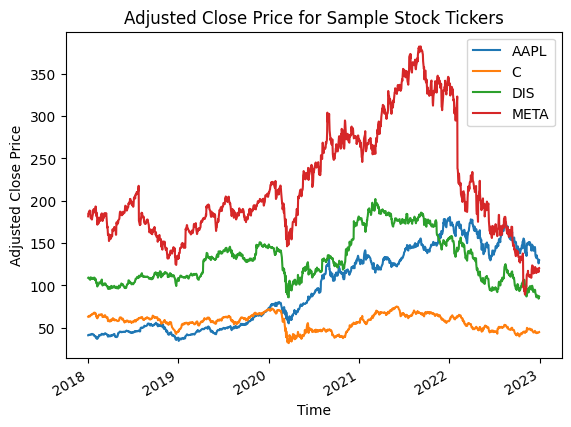

In [4]:
ax = df.plot.line(xlabel="Time", ylabel="Adjusted Close Price")
ax.set_title("Adjusted Close Price for Sample Stock Tickers")

## AAPL Percentage Change Histogram

Text(0.5, 1.0, 'Apple Percentage Change Histogram')

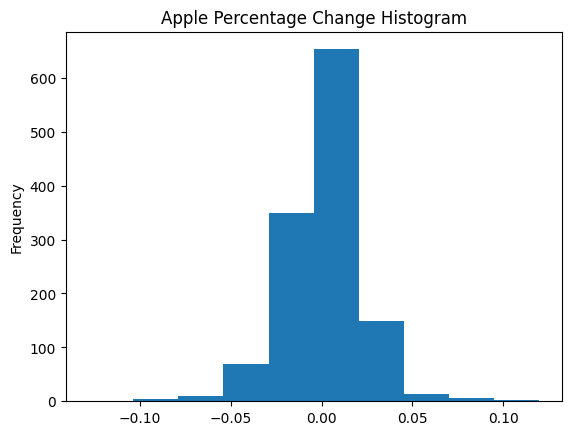

In [5]:
ax = df['AAPL'].pct_change().plot(kind='hist')
ax.set_title("Apple Percentage Change Histogram")

In [6]:
# Obtain percentage change per stock
returns = df.pct_change().dropna()

# Calculate the portfolio returns as the weighted average of the individual asset returns
weights = np.full((4), 0.25) # assuming equal weight
port_returns = (weights * returns).sum(axis=1) # weighted sum

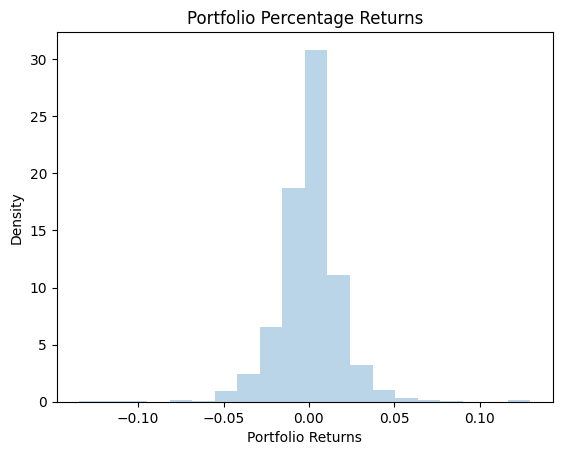

In [7]:
plt.hist(port_returns, bins=20, density=True, alpha=0.3)
plt.xlabel("Portfolio Returns")
plt.ylabel("Density")
plt.title(f"Portfolio Percentage Returns")
plt.show()

## 1. Historical Method

Assumption: **future** returns will follow a similar distribution to **historical** returns.

Therefore, no specific distribution for the portfolio returns.

In [8]:
# Assume initial portfolio value
initial_portfolio = 100000

# Obtain percentage change per stock
returns = df.pct_change()

# Calculate the portfolio returns as the weighted average of the individual asset returns
weights = np.full((4), 0.25) # assuming equal weight
port_returns = (weights * returns).sum(axis=1) # weighted sum

# Calculate the portfolio's VaR at 95% confidence level
confidence_level = 0.95
# Calculate P(Return <= VAR) = alpha
var = port_returns.quantile(q=1-confidence_level)
# Calculate CVAR by computing the average returns below the VAR level
cvar = port_returns[port_returns <= var].mean()

# Multiply the VaR and CVaR by the initial investment value to get the absolute value
var_value = var * initial_portfolio
cvar_value = cvar * initial_portfolio

print(f"Historical VaR at {confidence_level} confidence level: {var_value:.2f} ({var:.2%})")
print(f"Historical CVaR at {confidence_level} confidence level: {cvar_value:.2f} ({cvar:.2%})")


Historical VaR at 0.95 confidence level: -2873.26 (-2.87%)
Historical CVaR at 0.95 confidence level: -4403.11 (-4.40%)


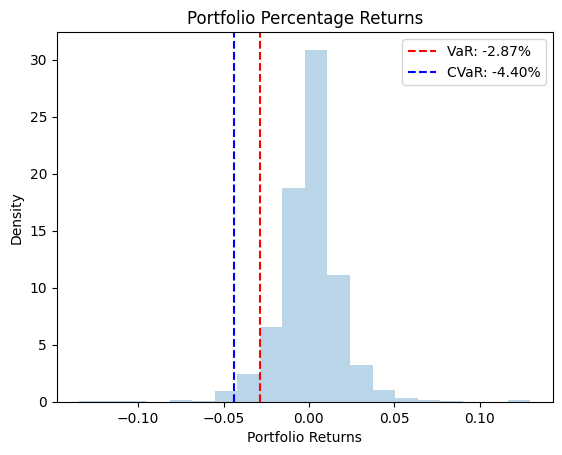

In [9]:
plt.hist(port_returns, bins=20, density=True, alpha=0.3)

# Add VAR CVAR to the histogram
plt.axvline(x=var, color='red', linestyle='--', label=f"VaR: {var:.2%}")
plt.axvline(x=cvar, color='blue', linestyle='--', label=f"CVaR: {cvar:.2%}")

plt.legend()
plt.xlabel("Portfolio Returns")
plt.ylabel("Density")
plt.title(f"Portfolio Percentage Returns")
plt.show()

## 2. Parametric Method (Variance-Covariance)

Assumption 1: returns follow a **normal distribution**

Assumption 2: normality

Calculates VaR based on the z-score corresponding to the confidence level (95%)

Calculates CVAR based on the assumption of normality and the tail value at the VaR level.

In [10]:
# Assume initial portfolio value
initial_portfolio = 100000

# Obtain percentage change per stock
returns = df.pct_change()

# Calculate mean and covariance matrix of returns
mean_returns = returns.mean()
cov_matrix = returns.cov()

# Calculate portfolio mean return and standard deviation
weights = np.full((4), 0.25)
port_mean_return = (weights * mean_returns).sum()
port_std_dev = np.sqrt(weights.T @ cov_matrix @ weights)

# Calculate VaR and CVaR using the parametric method
confidence_level = 0.95
z_score = norm.ppf(q=1-confidence_level)
var = - (norm.ppf(confidence_level)*port_std_dev - port_mean_return)
cvar = 1 * (port_mean_return - port_std_dev * (norm.pdf(z_score)/(1-confidence_level)))

var_initial = initial_portfolio * var
cvar_initial = initial_portfolio * cvar

print(f"Parametric VaR at {confidence_level} confidence level: {var_initial:.2f} ({var:.2%})")
print(f"Parametric CVaR at {confidence_level} confidence level: {cvar_initial:.2f} ({cvar:.2%})")


Parametric VaR at 0.95 confidence level: -2979.65 (-2.98%)
Parametric CVaR at 0.95 confidence level: -3744.60 (-3.74%)


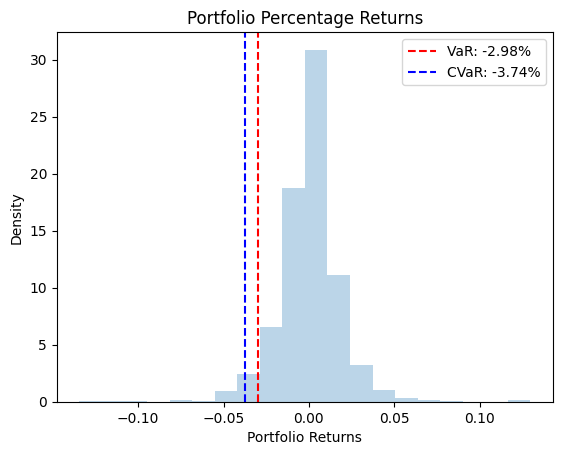

In [11]:
plt.hist(port_returns, bins=20, density=True, alpha=0.3)

# Add VAR CVAR to the histogram
plt.axvline(x=var, color='red', linestyle='--', label=f"VaR: {var:.2%}")
plt.axvline(x=cvar, color='blue', linestyle='--', label=f"CVaR: {cvar:.2%}")

plt.legend()
plt.xlabel("Portfolio Returns")
plt.ylabel("Density")
plt.title(f"Portfolio Percentage Returns")
plt.show()

## 3. Monte Carlo Simulation

Assumption: future returns of the portfolio follow a **multivariate normal distribution**, which may not be true in reality

In [12]:
# Set random seed for reproducibility
np.random.seed(123)

initialPortfolio = 100000

n_simulation = 400 # number of simulations
T = 252 # number of trading days in a year
weights = np.full((4), 0.25)
meanM = np.full(shape=(T, len(weights)), fill_value=mean_returns).T

sim_pct_change = np.full(shape=(T, n_simulation), fill_value=0.0)
for m in range(n_simulation):
    # Generate random numbers matrix for each day in the timeframe T and each stock in the portfolio
    Z = np.random.normal(size=(T, len(weights)))
    # Obtain the Cholesky decomposition of the covariance matrix
    # factoring the covariance matrix into the product of a lower triangular matrix (L) and its conjugate transpose (L*)
    L = np.linalg.cholesky(cov_matrix)
    # Calculate daily percentage change using the Cholesky decomposition
    daily_pct_change = meanM + np.inner(L, Z)
    # Calculate the simulated portfolio percentage change for each day in the timeframe T
    sim_pct_change[:,m] = np.inner(weights, daily_pct_change.T)


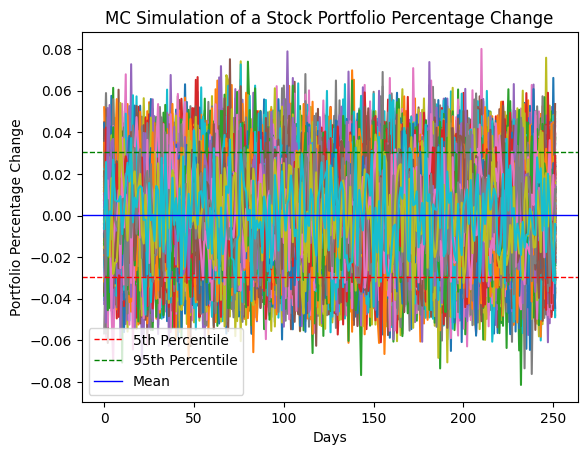

In [13]:
# Plotting
plt.plot(sim_pct_change)

plt.axhline(np.percentile(sim_pct_change,5), color='r', linestyle='dashed', linewidth=1, label='5th Percentile')
plt.axhline(np.percentile(sim_pct_change,95), color='g', linestyle='dashed', linewidth=1,  label='95th Percentile')
plt.axhline(np.mean(sim_pct_change), color='b', linestyle='solid', linewidth=1, label='Mean')

plt.legend()
plt.ylabel('Portfolio Percentage Change')
plt.xlabel('Days')
plt.title('MC Simulation of a Stock Portfolio Percentage Change')
plt.show()

In [14]:
confidence_level = 0.95
# Convert sim_returns to dataframe
port_pct_change = pd.Series(sim_pct_change[-1,:])
# Calculate the VAR and CVAR at 95% confidence level of the portfolio percentage change
mcVAR = port_pct_change.quantile(1 - confidence_level)
mcCVAR = port_pct_change[port_pct_change <= mcVAR].mean()

# Create data frame fill with 0
portfolio_returns = np.full(shape=(T, n_simulation), fill_value=0.0)

# Convert the percentage change to actual portfolio value
for m in range(n_simulation):
    portfolio_returns[:,m] = np.cumprod(sim_pct_change[:,m]+1)*initialPortfolio

# Select the last simulated trading day records
last_portfolio_returns = portfolio_returns[-1, :]
# Calculate the VAR and CVAR at 95% confidence level of the portfolio returns
mc_var_returns = np.percentile(last_portfolio_returns, 5)
mc_cvar_returns = last_portfolio_returns[last_portfolio_returns <= mc_var_returns].mean()

print(f"Monte Carlo VAR at 95% confidence level: ${mc_var_returns:.2f} ({mcVAR:.2%})")
print(f"Monte Carlo CVAR at 95% confidence level: ${mc_cvar_returns:.2f} ({mcCVAR:.2%})")

Monte Carlo VAR at 95% confidence level: $64215.77 (-3.09%)
Monte Carlo CVAR at 95% confidence level: $55416.67 (-3.74%)


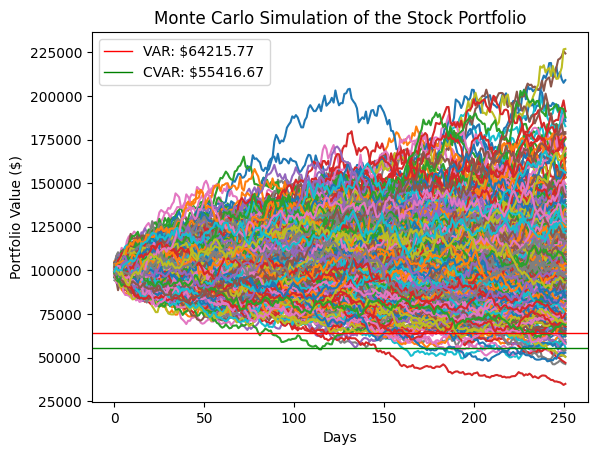

In [15]:
# Plotting
plt.plot(portfolio_returns)

plt.axhline(mc_var_returns, color='r', linewidth=1, label=f'VAR: ${mc_var_returns:.2f}')
plt.axhline(mc_cvar_returns, color='g', linewidth=1,  label=f'CVAR: ${mc_cvar_returns:.2f}')

plt.legend(loc='upper left')
plt.ylabel('Portfolio Value ($)')
plt.xlabel('Days')
plt.title('Monte Carlo Simulation of the Stock Portfolio')
plt.show()